In [60]:
import itertools
import os
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM, Flatten, TimeDistributed, Dropout, Conv2D
from tensorflow.keras.models import Sequential
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer 
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler 
from sklearn.preprocessing import minmax_scale
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm_notebook

# Define constants
person_count = 5
max_frames = 280


In [2]:
# print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

In [91]:
csv_dir = "dataset/csvs"

csv_files = os.listdir(csv_dir)

train_files, test_files = train_test_split(csv_files, train_size=0.8)

y_test_vals = []

minmax_scale = preprocessing.MinMaxScaler()
        
for file_name in tqdm_notebook(csv_files):
    csv = pd.read_csv(csv_dir + "/" + file_name)
    if len(csv) > 0:
        for label in csv.columns.values[2:]:
            minmax_scale = preprocessing.MinMaxScaler().partial_fit(csv[[label]])

C:\Users\Jack\anaconda3\lib\site-packages\ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


In [93]:
def prepare_data(file_names, scaler, limit=0):
    x = []
    y = []
    if limit != 0:
        file_names = file_names[:limit]
        
    
        
    for file_name in tqdm_notebook(file_names):

        csv = pd.read_csv(csv_dir + "/" + file_name)

        current_frame = 0

        violent = 0
        
        if len(csv) > 0:
            violent = csv.violent[0]

            csv = csv.drop('violent',axis=1)

            labels = csv.columns.values

            for label in labels[2:]:
                csv[[label]] = scaler.transform(csv[[label]])

            data = csv.to_numpy()

            val_cumulative = {}
            frame_ids = set()
            for person in data:
                frame_ids.add(person[0])
                frame, person_id = person[:2]

                vel_array = []
                for vel in range(5, 70, 4):
                    vel_array.append(vel)

                total_vel = sum(vel_array)

                if person_id in val_cumulative:
                    val_cumulative[person_id] += total_vel
                else:
                    val_cumulative[person_id] = 0


            val_cumulative = {k: v for k, v in sorted(val_cumulative.items(), key=lambda item: item[1], reverse=True)}
            top_people = dict(itertools.islice(val_cumulative.items(), person_count))
            top_people_dataset = {}

            starter_map = {}
            for key in top_people.keys():
                starter_map[key] = np.zeros(68)

            for frame_id in frame_ids:
                # Trim to 280 if above
                if current_frame == max_frames:
                    break
                tmp_map = starter_map
                people = np.array([item for item in data if item[0] == frame_id and item[1] in top_people.keys()])
                for person in people:
                    tmp_map[person[1]] = person[2:]

                padded = list(tmp_map.values())

                for i in range(len(padded), person_count):
                    padded.append(np.zeros(68))

                top_people_dataset[frame_id] = np.asarray(padded)
                current_frame += 1


        # Pad to 280 frames if below
        for i in range(current_frame+1, max_frames+1):
            top_people_dataset[i] = []
            for j in range(0, person_count):
                top_people_dataset[i].append(np.zeros(68))

        tmp = np.asarray(list(top_people_dataset.values()))

        for entry in tmp:
            x.append(entry)

        if violent == 0:
            for entry in np.zeros(len(tmp)):
                y.append(entry)
        else:
            for entry in np.ones(len(tmp)):
                y.append(entry)
        
    return (np.asarray(list(x)), np.asarray(list(y)))

In [94]:
x_train, y_train = prepare_data(train_files, minmax_scale)

C:\Users\Jack\anaconda3\lib\site-packages\ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


In [95]:
x_train.shape

(436801, 5, 68)

In [96]:
y_train.shape

(436801,)

In [83]:
model = Sequential()
model.add(TimeDistributed(Flatten(input_shape=(5, 68))))
model.add(LSTM(100, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.build(input_shape=(280, 5, 68))
model.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_18 (TimeDis multiple                  0         
_________________________________________________________________
lstm_26 (LSTM)               multiple                  67600     
_________________________________________________________________
dropout_26 (Dropout)         multiple                  0         
_________________________________________________________________
lstm_27 (LSTM)               multiple                  30200     
_________________________________________________________________
dropout_27 (Dropout)         multiple                  0         
_________________________________________________________________
dense_17 (Dense)             multiple                  51        
Total params: 97,851
Trainable params: 97,851
Non-trainable params: 0
_________________________________________________

In [97]:
history = model.fit(x_train, y_train, epochs=10, batch_size=100, validation_split=0.2)

Train on 349440 samples, validate on 87361 samples
Epoch 1/10
349440/349440 [==============================] - 39s 112us/sample - loss: 0.5913 - accuracy: 0.6400 - val_loss: 0.5875 - val_accuracy: 0.6474
Epoch 2/10
349440/349440 [==============================] - 41s 116us/sample - loss: 0.5626 - accuracy: 0.6575 - val_loss: 0.5795 - val_accuracy: 0.6481
Epoch 3/10
349440/349440 [==============================] - 47s 136us/sample - loss: 0.5492 - accuracy: 0.6657 - val_loss: 0.5749 - val_accuracy: 0.6545
Epoch 4/10
349440/349440 [==============================] - 46s 133us/sample - loss: 0.5369 - accuracy: 0.6717 - val_loss: 0.5838 - val_accuracy: 0.6531
Epoch 5/10
349440/349440 [==============================] - 42s 121us/sample - loss: 0.5261 - accuracy: 0.6773 - val_loss: 0.5853 - val_accuracy: 0.6503
Epoch 6/10
349440/349440 [==============================] - 50s 143us/sample - loss: 0.5219 - accuracy: 0.6797 - val_loss: 0.5876 - val_accuracy: 0.6572
Epoch 7/10
349440/349440 [=====

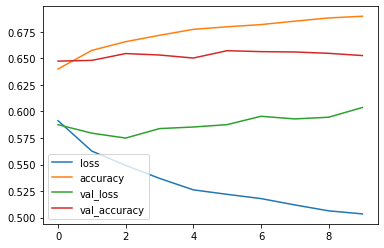

In [98]:
pd.DataFrame(history.history).plot()

In [99]:
x_test, y_test = prepare_data(test_files, minmax_scale)

C:\Users\Jack\anaconda3\lib\site-packages\ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


In [100]:
x_test.shape

(109480, 5, 68)

In [15]:
y_test.shape

(109480,)

In [101]:
scores = model.evaluate(x_test, y_test, verbose=1)
scores

109480/109480 [==============================] - ETA: 0s - loss: 0.6008 - accuracy: 0.63 - 11s 103us/sample - loss: 0.6009 - accuracy: 0.6375


[0.6009306807650211, 0.6374863]

In [102]:
y_pred = model.predict(x_test, verbose=1)
y_pred.shape

109480/109480 [==============================] - 9s 83us/sample


(109480, 1)

In [ ]:
y_true = []
for i in y_test:
    y_true.append([i])

y_true = np.asarray(y_true)

for i in y_pred:
    print(i)

print(y_true)
print(y_pred)
    

In [105]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(y_true.argmax(axis=1), y_pred.argmax(axis=1))

In [106]:
matrix

array([[109480]], dtype=int64)

array([[0.47885376],
       [0.47885376],
       [0.47885376],
       ...,
       [0.47885376],
       [0.47885376],
       [0.47885376]], dtype=float32)